# Подготовка данных для обучения

В папке dataset есть 2 директории с фотографиями: "with_mask" и "without_mask". 

In [1]:
import os
import numpy as np
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
DIRECTORY = os.path.join(os.getcwd(), 'dataset')
DIRECTORY

'C:\\Users\\User\\Documents\\Face mask detection\\dataset'

In [3]:
categories = ["without_mask", "with_mask"]

photos = []
labels = []

for category in categories:
    limit = 800
    path = os.path.join(DIRECTORY, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        image    = load_img(img_path, target_size=(224, 224))
        image    = img_to_array(image)
        photos.append(image)
        labels.append(category)
        limit -= 1
        if limit == 0:
            break
        
labels = np.array(labels).reshape((-1,1))
photos = np.array(photos)

In [4]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(labels)

In [5]:
print("Shape of labels array {}".format(labels.shape))
print("Shape of photos array {}".format(photos.shape))

Shape of labels array (1600, 2)
Shape of photos array (1600, 224, 224, 3)


# Разбиваем данные на train и test

На train будет обучаться модель, на test будет происходить валидация.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size=0.3, random_state=1)

print("Shape of X_train array is {}".format(X_train.shape))
print("Shape of y_train array is {}".format(y_train.shape))

print("\nShape of X_test  array is {}".format(X_test.shape))
print("Shape of y_test  array is {}".format(y_test.shape))

Shape of X_train array is (1120, 224, 224, 3)
Shape of y_train array is (1120, 2)

Shape of X_test  array is (480, 224, 224, 3)
Shape of y_test  array is (480, 2)


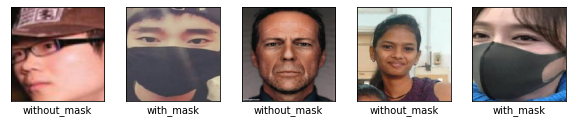

In [7]:
import matplotlib.pyplot as plt

def show_n_photos(n, photos, labels):
    plt.figure(figsize=(10, 10))

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(photos[i].astype('int'))
        plt.xlabel(enc.inverse_transform(labels[i:i+1])[0, 0])

show_n_photos(5, X_train, y_train)

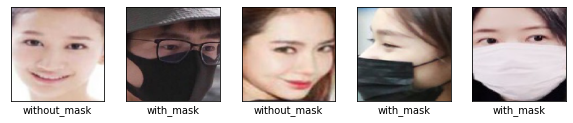

In [8]:
show_n_photos(5, X_test, y_test)

# Обучение модели

In [9]:
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

In [27]:
inp_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

model     = inp_model.output
model     = AveragePooling2D(pool_size=(7, 7))(model)
model     = Flatten()(model)
model     = Dense(128, activation='relu')(model)
model     = Dropout(0.5)(model)
model     = Dense(2, activation='softmax')(model)

model     = Model(inputs=inp_model.input, outputs=model)

In [28]:
for layer in inp_model.layers:
    layer.trainable = False
    
optimizer = Adam(lr=1e-4, decay = 5e-6)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [29]:
batch_size = 32
epochs     = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) // batch_size, validation_steps=len(X_test) // batch_size)

Train on 1120 samples, validate on 480 samples
Epoch 1/10
1120/1120 [==============================] - 196s 175ms/sample - loss: 0.3212 - accuracy: 0.8616 - val_loss: 0.6486 - val_accuracy: 0.6521
Epoch 2/10
1120/1120 [==============================] - 196s 175ms/sample - loss: 0.1384 - accuracy: 0.9536 - val_loss: 1.1186 - val_accuracy: 0.5229
Epoch 3/10
1120/1120 [==============================] - 270s 241ms/sample - loss: 0.0564 - accuracy: 0.9795 - val_loss: 0.9810 - val_accuracy: 0.5604
Epoch 4/10
1120/1120 [==============================] - 293s 261ms/sample - loss: 0.0807 - accuracy: 0.9679 - val_loss: 0.8755 - val_accuracy: 0.6250
Epoch 5/10
1120/1120 [==============================] - 302s 269ms/sample - loss: 0.0684 - accuracy: 0.9714 - val_loss: 0.9382 - val_accuracy: 0.6229
Epoch 6/10
1120/1120 [==============================] - 287s 256ms/sample - loss: 0.0607 - accuracy: 0.9795 - val_loss: 0.6095 - val_accuracy: 0.6833
Epoch 7/10
1120/1120 [==============================]

In [55]:
model.save("face_mask_detector.model", save_format="h5")

# Нарисуем прогресс обучения

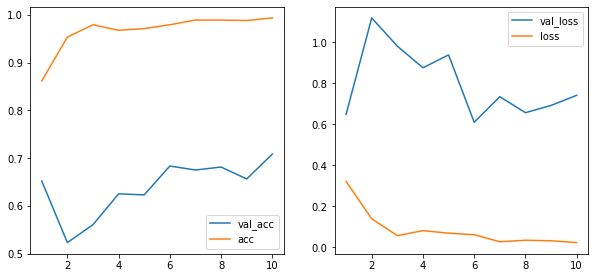

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, 11), history.history['val_accuracy'], label='val_acc')
plt.plot(range(1, 11), history.history['accuracy'],     label='acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, 11), history.history['val_loss'], label='val_loss')
plt.plot(range(1, 11), history.history['loss'],     label='loss')
plt.legend()

# Матрица ошибок

In [52]:
from sklearn.metrics import confusion_matrix

prediction = model.predict(X_test)
prediction = np.apply_along_axis(np.round, axis=1, arr=prediction)

conf_m = confusion_matrix(y_test[:, 0].flatten(), prediction[:, 0].flatten())

In [54]:
tn, fp, fn, tp = conf_m.flatten()
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", fn)

True Positives: 214
False Positives: 99
False Negatives: 28
True Negatives: 28


$$ Precision =  \frac{TP}{TP + FP} = 0,68 $$

$$ Recall =  \frac{TP}{TP + FN} = 0,88 $$

Модель часто принимает фотографии без масок за класс with_mask (много false positives) => Точность невысокая.

# И посмотрим, как сработает модель на фотографиях друзей

In [42]:
DIRECTORY = os.path.join(os.getcwd(), 'friends_photo')

friends_photos = []

for friend in os.listdir(DIRECTORY):
    img_path = os.path.join(DIRECTORY, friend)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    friends_photos.append(image)
    
friends_photos = np.array(friends_photos)

N_friends = len(friends_photos)

In [43]:
prediction = model.predict(friends_photos)
prediction

array([[0.48401216, 0.5159879 ],
       [0.99730384, 0.0026962 ],
       [0.28144386, 0.7185561 ],
       [0.9220154 , 0.07798453],
       [0.2682544 , 0.73174554],
       [0.9344783 , 0.06552171],
       [0.53656304, 0.46343702]], dtype=float32)

In [44]:
prediction = np.apply_along_axis(np.round, axis=1, arr=prediction)
prediction

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

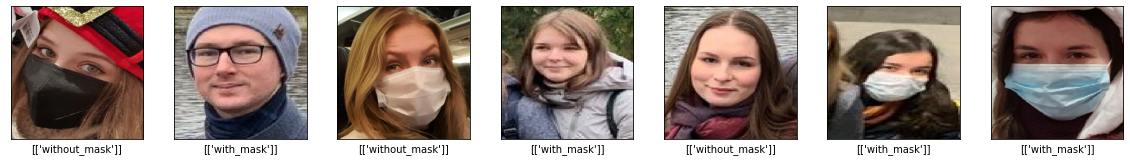

In [45]:
plt.figure(figsize=(20, 20))

for i in range(N_friends):
    plt.subplot(N_friends, N_friends, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(friends_photos[i].astype('int'))
    plt.xlabel(enc.inverse_transform([prediction[i]]))

Модель верно определила классы только для 3х фотографий, (2 true positive, 1 true negative, 2 false positive, 2 false negative)

# Что бы еще попробовала? Как бы улучшила результат? 

- Попробовала бы использовать аугментацию: делала бы небольшие изменения фотографий (поворот, смещение, яркость и т.д.)
- Другой вариант был построить сверточную сеть, но модель с MobileNetV2 дала лучший результат.
- Сейчас количество картинок ограничивала (не справлялась оперативка), попробовала бы работать с большим числом картинок.
- Попробовала бы задействовать GridSearchCV для выбора оптимальных параметров.
- Определенно не хватало вычислительной мощности.